RECUPERATION DE LA LISTE DE TOUS LES ETABLISSEMENTS (AVEC CHANGEMENTS DE PAGE)

In [2]:
import os
import logging
import scrapy
from scrapy.crawler import CrawlerProcess
import plotly.express as px
import pandas as pd
import json
import requests

SI LA LISTE BASIQUE DES ETABLISSEMENTS N'A PAS DEJA ETE ENREGISTREE EN JSON ON VA LA RECUPERER

In [2]:
filename = 'toutes_les_pages.json'

if filename in os.listdir("src/"):
    le_fichier_existe = True
    print("le fichier existe")
    df = pd.DataFrame(pd.read_json('src/'+filename), dtype='str')
else:
    print("Le fichier existe pas")
    le_fichier_existe = False

le fichier existe


ON RECUPERE LA LISTE BASIQUE DES ETABLISSEMENTS (CHANGER EN PYTHON POUR L'UTILISER)

class SFAPSpider(scrapy.Spider):
    # Name of your spider
    name = "sfap"

    # Url to start your spider from
    start_urls = [
        'https://sfap.org/annuaire?contact_sub_type=Structure&type_6%5B%5D=USP&type_6%5B%5D=LISP'
    ]

    # Callback function that will be called when starting your spider
    def parse(self, response):
        # retourne une liste de tous les éléments de classe "quote" 
        entrees = response.css('tbody tr')
        for entree in entrees:
            nom = entree.css('td.views-field-display-name a::text').get()
            type = entree.css('td.views-field-type-6::text').get()
            adresse = entree.css('td.views-field-street-address::text').get()
            code_postal = entree.css('td.views-field-postal-code::text').get()
            commune = entree.css('td.views-field-city::text').get()
            telephone = entree.css('td.views-field-phone::text').get()
            yield {
                'nom': nom,
                'type':type.strip('\n').strip(),
                'adresse':adresse.strip('\n').strip(),
                'code_postal':code_postal.strip('\n').strip(),
                'commune':commune.strip('\n').strip(),
                'telephone':telephone.strip('\n').strip()
            }
        try:
            next_page = response.css('li.pager-next a').attrib['href']
        except:
            logging.info("No next page")
        else:
            yield response.follow(next_page, callback=self.parse)

if le_fichier_existe==False:
    filename = 'toutes_les_pages.json'

    if filename in os.listdir("src/"):
        os.remove('src/'+filename)

    process = CrawlerProcess(settings={
        'USER_AGENT': 'Chrome/97.0',
        'LOG_LEVEL': logging.INFO,
        'FEEDS':{
            'src/' + filename : {"format": "json", 'encoding': 'utf8'},
            },
        "AUTOTHROTTLE_ENABLED": True
    }
    )

    #Lancer le crawler utilisant la spider
    process.crawl(SFAPSpider)
    process.start()

ON VA SUR CHAQUE PAGE POUR RECUPERER DES INFOS SUPPLEMENTAIRES

In [101]:
filename = 'toutes_les_pages_completes.json'

if filename in os.listdir("src/"):
    le_fichier_existe = True
    print("le fichier existe")
    df = pd.DataFrame(pd.read_json('src/'+filename), dtype='str')

else:
    print("Le fichier existe pas")
    le_fichier_existe = False

le fichier existe


SI LE FICHIER N'EXISTE PAS ON SCRAP LES INFOS POUR TOUS LES ETABLISSEMENTS (~ 6 MINUTES)

In [5]:
class SFAPSpider(scrapy.Spider):
    # Name of your spider
    name = "sfap"

    # Url to start your spider from
    start_urls = [
        'https://sfap.org/annuaire?contact_sub_type=Structure&type_6%5B%5D=USP&type_6%5B%5D=LISP'
    ]

    # Callback function that will be called when starting your spider
    def parse(self, response):
        # retourne une liste de tous les établissements
        entrees = response.css('tbody tr')
        for entree in entrees:
            nom = entree.css('td.views-field-display-name a::text').get()
            url = entree.css('td.views-field-display-name a').attrib['href']
            type = entree.css('td.views-field-type-6::text').get()
            adresse = entree.css('td.views-field-street-address::text').get()
            code_postal = entree.css('td.views-field-postal-code::text').get()
            commune = entree.css('td.views-field-city::text').get()
            telephone = entree.css('td.views-field-phone::text').get()
            infos= {
                'nom': nom,
                'type':type.strip('\n').strip(),
                'adresse':adresse.strip('\n').strip(),
                'code_postal':code_postal.strip('\n').strip(),
                'commune':commune.strip('\n').strip(),
                'telephone':telephone.strip('\n').strip()
            }

            yield scrapy.Request("https://sfap.org"+url, callback=self.details, cb_kwargs = {'infos':infos})
                
        try:
            next_page = response.css('li.pager-next a').attrib['href']
        except:
            logging.info("No next page")
        else:
            yield response.follow(next_page, callback=self.parse)

    # ON VA SUR CHAQUE PAGE ET ON CHOPE TOUS LES CHAMPS
    def details(self, response, infos):
        lignes = response.css('div.form-item')
        for ligne in lignes:
            label  = ligne.xpath('./label//text()').get().strip()
            if label in infos:
                label = f"{label}_2"
            valeur = ligne.xpath('./div//text()').get()
            if valeur is None:
                valeur = ligne.css('input::attr(value)').get()

            update= {
                label: valeur
            }
            infos.update(update)
        yield infos


if le_fichier_existe ==False:
    filename = 'toutes_les_pages_completes.json'

    if filename in os.listdir("src/"):
        os.remove('src/'+filename)


    process = CrawlerProcess(settings={
        'USER_AGENT': 'Chrome/97.0',
        'LOG_LEVEL': logging.WARNING,
        'FEEDS':{
            'src/' + filename : {"format": "json", 'encoding': 'utf8'},
            },
        "AUTOTHROTTLE_ENABLED": True
        }
    )

    #Lancer le crawler utilisant la spider
    process.crawl(SFAPSpider)
    process.start()

2024-11-18 09:16:01 [py.warnings] WARNING: c:\Users\Admin\anaconda3\Lib\site-packages\scrapy\utils\request.py:254: ScrapyDeprecationWarning: '2.6' is a deprecated value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting.

It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting for information on how to handle this deprecation.
  return cls(crawler)



ON CHARGE LE JSON DANS UN DATAFRAME

In [12]:
# Open and read the JSON file
with open('src/toutes_les_pages_completes.json', 'r') as file:
    data = json.load(file)

df = pd.DataFrame(data)

ON FAIT UNE COPIE AU CAS OU

In [7]:
df_backup = df

AJOUT DES LATITUDES ET LONGITUDES DE CHAQUE ETABLISSEMENT

In [3]:
filename = 'backup_infos_avec_coordonnees.csv'

if filename in os.listdir("src/"):
    le_fichier_existe = True
    print("le fichier existe")
    df = pd.DataFrame(pd.read_csv('src/'+filename), dtype='str')
    df['lat'] = df['lat'].astype('float64')
    df['lon'] = df['lon'].astype('float64')
else:
    print("Le fichier existe pas")
    le_fichier_existe = False

le fichier existe


SI LE FICHIER CSV N'EXISTE PAS ENCORE ON RECUPERE TOUTES LES COORDONNEES

In [ ]:

if le_fichier_existe == False:
    # RECUPERATION DES DONNEES POUR TOUTE LA LISTE DES VILLES
    url = "https://nominatim.openstreetmap.org/search?"
    headers = {'user_agent':'charles.mittempergher@gmail.com'}

    lats = []
    longs = []

    for i in range(0,len(df)):
        street = df.loc[i,'adresse']
        postal_code = df.loc[i,'code_postal']
        p = {'street':{street},'postalcode' : {postal_code},'country':'France', 'format':'json', 'limit':1, 'email':'charles@gmail.com'}
        r = requests.get(url, headers=headers, params=p)

        lat = None
        lon = None
        if len(r.json())>0:
            lats.append(r.json()[0]['lat'])
            longs.append(r.json()[0]['lon'])
        else:
            lats.append(None)
            longs.append(None)

        print(f'{i}/{len(df)} ({round(i/len(df)*100,2)}%)')
        print('*************************')

    df.insert(loc=len(df.columns), column='lat', value=lats)
    df.insert(loc=len(df.columns), column='lon', value=longs)
    df['lat'] = df['lat'].astype('float64')
    df['lon'] = df['lon'].astype('float64')

    df.to_csv("src/backup_infos_avec_coordonnees.csv", index=False)

ON A RECUPERE TOUS LES CHAMPS, 
TODO:
- RELANCER LE SCRAPPING CAR ERREUR 500 LA DERNIERE FOIS, ON A QUE 121 LIGNES SUR 372
- IL FAUT NETTOYER LES COLONNES NB DES LITS 1 & 2 (ENLEVER LES NAN ET TRANSFORMER EN INT)
- AFFICHER SUR LA CARTE AVEC SIZE = NB LITS TOTAUX
- + d'autres choses....



ON NETTOIE LES CHAMPS "NOMBRE DE LITS"

In [48]:
df['Nombre des lits'] = df['Nombre des lits'].apply(lambda x: '0' if x=="nan" else x)
df['Nombre des lits_2'] = df['Nombre des lits_2'].apply(lambda x: '0' if x=="nan" else x)

In [49]:
df['Nombre des lits'] = df['Nombre des lits'].apply(lambda x: x.split('.')[0])
df['Nombre des lits_2'] = df['Nombre des lits_2'].apply(lambda x: x.split('.')[0])

In [50]:
df['Nombre des lits'] = df['Nombre des lits'].astype('int64')
df['Nombre des lits_2'] = df['Nombre des lits_2'].astype('int64')

ON CALCULE LE TOTAL DANS UNE NOUVELLE COLONNE

In [51]:
df["total_lits"] = df.apply(lambda x: x['Nombre des lits']+x['Nombre des lits_2'], axis=1)

In [52]:

fig = px.scatter_mapbox(df,lat="lat", lon="lon",  hover_name="nom", height=700, size='total_lits',
mapbox_style="open-street-map",title='Carte des lits SP',zoom=4.5,color_continuous_scale=["red","orange","yellowgreen","green"])
fig.update_layout(title_x=0.5)
fig.show()

INFOS DE PAGES PRECISES (ESSAIS)

<Axes: xlabel='total_lits'>

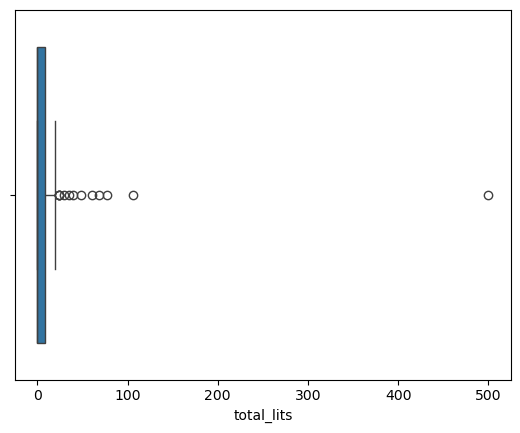

In [126]:
import seaborn as sns

sns.boxplot(df, x='total_lits')

ON FAIT DU TRI ET DU MENAGE DANS LA COLONNE ZONE TEXTE LIBRE, ON VEUT GARDER QUE LES INFOS QUI CONCERNENT DES LITS OU DES LISP

In [ ]:
df['Zone de notes libres'].unique()

In [53]:
df.head()

,nom,type,adresse,code_postal,commune,telephone,Rechercher,Nom de l'établissement,Type de structure,"Bât, résidence, escalier...",...,Psychologue(s),Autres,Présence de bénévoles,Associations de bénévoles présentes,Zone de notes libres,Unnamed: 54,Website URL,lat,lon,total_lits
0,CHI DES ALPES DU SUD - USP,USP,1 place Auguste Muret,05007,GAP,04 92 40 69 20,nan,CHI DES ALPES DU SUD - USP,USP,USP 05 - Site ADRET,...,Non précisé,Non précisé,Non précisé,Non précisé,nan,nan,nan,NaN,NaN,0
1,CH GÉRONTOLOGIQUE LA FERE - USP,USP,2 avenue Dupuis,02800,LA FERE,03 23 56 67 00,nan,CH GÉRONTOLOGIQUE LA FERE - USP,USP,nan,...,Non précisé,Non précisé,Non précisé,Non précisé,Présence de bénévoles de JALMALV.,nan,nan,49.663249,3.360378,0
2,HÔPITAL VILLIERS SAINT-DENIS,LISP,41 rue Victor et Louise Monfort,02310,VILLIERS SAINT-DENIS,03 23 70 74 77,nan,HÔPITAL VILLIERS SAINT-DENIS,LISP,Service de soins de suite et palliatifs,...,0.5,Non précisé,Non,Non précisé,6 lits identifiés,nan,nan,NaN,NaN,6
3,CH GÉNÉRAL DE SOISSONS - USP,USP,46 avenue du Général de Gaulle,02209,SOISSONS CEDEX,03 23 75 71 29,nan,CH GÉNÉRAL DE SOISSONS - USP,USP,nan,...,Non précisé,Non précisé,Non précisé,Non précisé,nan,nan,nan,48.580576,7.690289,0
4,CH DU NOUVION EN THIERARCHE - LISP,LISP,40 rue André Ridders,02170,LE NOUVION EN THIERARCHE,03 23 97 56 33,nan,CH DU NOUVION EN THIERARCHE - LISP,LISP,Service de médecine de moyen séjour,...,Non précisé,Non précisé,Non précisé,Non précisé,4 lits Identifiés,nan,nan,50.014512,3.780694,0


SI CA CONTIENT "LITS" OU "LISP" C'EST DES INFOS QU'ON VEUT DONC ON LES GARDE, SINON ON s'EN FICHE UN PEU

In [ ]:
df['lits_ou_lisp_zone_libre'] = df['Zone de notes libres'].apply(lambda x : x if "lits" in x or "LISP" in x else 0) 

ON AIME PAS LES NAN DONC ON LES REMPLACE PAR 0

In [10]:
df['lits_zone_libre'] = df['lits_zone_libre'].fillna("0")

In [ ]:
df['lits_zone_libre'].unique()


In [12]:
liste_textes = df['lits_zone_libre'].unique()

In [ ]:
import re
x = []
for i in liste_textes:
    if i!=0:
        x.append(re.findall("\d\d?\d?[ ][Ll][Ii][Tt][Ss]",i))
        x.append(re.findall("\d\d?[ ][Ll][Ii][Ss][Pp]",i))

6 lits identifiés
4 lits Identifiés
4 lits identifiés
10 lits identifiés en soins palliatifs MCO
4 lits de SSR polyvalent à orientation palliative
USP de 12 lits
Capacité d'accueil: 30 lits en SSR  et en SP.
 présence de bénévoles. Rayon d'intervention en Ardèche mais accueil élargi.
Service constitué d'une USP de 6 lits  et 4 lits d'oncologie

4 lits dédiés
Rayon d'action sur le 24 est de 30 km.
4 à  5 lits identifiés pour des patients de la région.
3 à  5 lits en chambres indidividuelles pour des malades en soins palliatifs
6 lits identifiés; 3 IDE; un medecin formés aux SP
8 lits identifiés
2 lits identifiés.
Capacité d'accueil : 5 lits. présence de bénévoles d'Actes
cette structure dépend du CHU de Brest.

10 lits identifiés.
2 lits

Intervention sur le Finistère Nord et la moitié des Côtes d'armor
service medecine 4 lits identifiés; accueil de stagiaires IDE uniquement.
11 lits identifiés
14 lits identifiés : 8 en court séjour, 6 en soins de suite
9 lits identifiés en court séjour

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Admin\AppData\Local\Temp\ipykernel_12128\1359725465.py:6: SyntaxWarning: invalid escape sequence '\d'
  x.append(re.findall("\d\d?\d?[ ][Ll][Ii][Tt][Ss]",i))
C:\Users\Admin\AppData\Local\Temp\ipykernel_12128\1359725465.py:7: SyntaxWarning: invalid escape sequence '\d'
  x.append(re.findall("\d\d?[ ][Ll][Ii][Ss][Pp]",i))


In [34]:
x

[['6 lits'],
 [],
 ['4 lits'],
 [],
 ['4 lits'],
 [],
 ['10 lits', '4 lits'],
 [],
 ['12 lits'],
 [],
 ['30 lits'],
 [],
 ['6 lits', '4 lits'],
 [],
 ['4 lits'],
 [],
 ['5 lits'],
 [],
 ['5 lits'],
 [],
 ['6 lits'],
 [],
 ['8 lits'],
 [],
 ['2 lits'],
 [],
 ['5 lits'],
 [],
 ['10 lits'],
 [],
 ['2 lits'],
 [],
 ['4 lits'],
 [],
 ['11 lits'],
 [],
 ['14 lits'],
 [],
 ['9 lits', '5 lits'],
 [],
 ['14 lits'],
 [],
 ['24 lits'],
 [],
 ['12 lits'],
 [],
 [],
 [],
 [],
 [],
 ['12 lits'],
 [],
 ['3 lits'],
 [],
 ['15 lits'],
 [],
 ['8 lits'],
 [],
 ['18 lits'],
 [],
 ['6 lits'],
 [],
 ['4 lits'],
 [],
 ['12 lits'],
 [],
 [],
 ['3 LISP'],
 ['5 lits'],
 [],
 ['5 lits'],
 [],
 ['6 lits'],
 [],
 ['6 lits'],
 [],
 ['14 lits'],
 [],
 ['3 lits'],
 [],
 ['3 lits'],
 [],
 ['5 lits'],
 [],
 ['5 lits'],
 [],
 ['8 lits'],
 [],
 ['5 lits'],
 [],
 ['3 lits'],
 [],
 ['5 lits'],
 [],
 ['5 lits'],
 [],
 ['5 lits'],
 [],
 ['2 lits'],
 [],
 ['5 lits'],
 [],
 ['6 lits'],
 [],
 ['11 lits'],
 [],
 ['10 lits'],
 []

SI LA ZONE DE TEXTE CONTIENT "LITS" OU "LISP", ON EXTRAIT LE NOMBRE ASSOCIE ET LE TYPE DE LITS

In [ ]:
import re

def recherche_nb_lits(x):
    liste = []
    liste_lits = re.findall("\d\d?\d?[ ][Ll][Ii][Tt][Ss]",x)
    if len(liste_lits)>0:
        liste.append(liste_lits)
    return liste

def recherche_nb_LISP(x):
    liste = []
    liste_lisp = re.findall("\d\d?[ ][Ll][Ii][Ss][Pp]",x)
    if len(liste_lisp)>0:
        liste.append(liste_lisp)
    return liste

In [ ]:
df['liste_lits_zone_libres']= df['Zone de notes libres'].apply(lambda x: recherche_nb_lits(x) if x!=0 else x)
df['liste_LISP_zone_libres']= df['Zone de notes libres'].apply(lambda x: recherche_nb_LISP(x) if x!=0 else x)

In [94]:
def total(liste):
    sum = 0
    print(liste)
    for i in liste: 
        for k in i:
            print(k)
            sum += int(str(k).split(' ')[0])
        
    return sum

def total_backup(liste):
    sum = 0
    for i in liste: 
        idx = 0
        print(i[idx])
        sum += int(str(i[idx]).split(' ')[0])
        idx +=1
    return sum

df['total_valeurs_lits_zone_libres'] = df['liste_lits_zone_libres'].apply(lambda x : total(x))
df['total_valeurs_LISP_zone_libres'] = df['liste_LISP_zone_libres'].apply(lambda x : total(x))

[]
[]
[['6 lits']]
6 lits
[]
[['4 lits']]
4 lits
[['4 lits']]
4 lits
[]
[['10 lits', '4 lits']]
10 lits
4 lits
[]
[['12 lits']]
12 lits
[]
[]
[]
[['10 LITS']]
10 LITS
[]
[]
[]
[['30 lits']]
30 lits
[['6 lits', '4 lits']]
6 lits
4 lits
[]
[]
[['4 lits']]
4 lits
[]
[]
[['5 lits']]
5 lits
[]
[]
[]
[]
[]
[]
[]
[['5 lits']]
5 lits
[]
[['6 lits']]
6 lits
[]
[['8 lits']]
8 lits
[]
[['2 lits']]
2 lits
[]
[]
[]
[]
[]
[['5 lits']]
5 lits
[]
[['10 lits']]
10 lits
[['2 lits']]
2 lits
[]
[['4 lits']]
4 lits
[['11 lits']]
11 lits
[['14 lits']]
14 lits
[['9 lits', '5 lits']]
9 lits
5 lits
[]
[]
[['14 lits']]
14 lits
[]
[]
[['24 lits']]
24 lits
[['8 lits']]
8 lits
[]
[]
[]
[]
[['12 lits']]
12 lits
[]
[]
[]
[]
[]
[['12 lits']]
12 lits
[['3 lits']]
3 lits
[]
[['15 lits']]
15 lits
[['8 lits']]
8 lits
[]
[]
[['18 lits']]
18 lits
[]
[]
[]
[]
[['14 Lits']]
14 Lits
[['6 lits']]
6 lits
[['4 Lits']]
4 Lits
[['4 Lits']]
4 Lits
[['4 lits']]
4 lits
[['12 lits']]
12 lits
[]
[]
[['5 lits']]
5 lits
[]
[]
[['5 lits']

In [95]:
df['total_valeurs_lits_zone_libres'].unique()

array([  0,   6,   4,  14,  12,  10,  30,   5,   8,   2,  11,  24,   3,
        15,  18,   7,  20,  80,   9,  29, 323, 220,  36, 101], dtype=int64)

In [96]:
df['total_valeurs_LISP_zone_libres'].unique()

array([ 0,  3,  6,  4, 10,  2, 12,  8, 16, 14], dtype=int64)

In [97]:
df['nombre_pertinent'] = df.apply(lambda x : x['total_valeurs_LISP_zone_libres'] if x['total_valeurs_LISP_zone_libres']>0 else x['total_valeurs_lits_zone_libres'], axis=1)

In [98]:
df["nombre_pertinent"].unique()

array([  0,   6,   4,  14,  12,  10,  30,   5,   8,   2,  11,  24,   3,
        15,  18,   7,  20,  80,   9,  29, 323, 220,  16,  36], dtype=int64)

In [99]:

fig = px.scatter_mapbox(df,lat="lat", lon="lon",  hover_name="nom", height=700, size='nombre_pertinent', color='type',
mapbox_style="open-street-map",title='Carte des lits SP',zoom=4.5,color_continuous_scale=["red","orange","yellowgreen","green"])
fig.update_layout(title_x=0.5)
fig.show()

In [4]:
df

,nom,type,adresse,code_postal,commune,telephone,Rechercher,Nom de l'établissement,Type de structure,"Bât, résidence, escalier...",...,Assistant(e)(s) social(e),Psychologue(s),Autres,Présence de bénévoles,Associations de bénévoles présentes,Zone de notes libres,Unnamed: 54,Website URL,lat,lon
0,CHI DES ALPES DU SUD - USP,USP,1 place Auguste Muret,05007,GAP,04 92 40 69 20,nan,CHI DES ALPES DU SUD - USP,USP,USP 05 - Site ADRET,...,Non précisé,Non précisé,Non précisé,Non précisé,Non précisé,nan,nan,nan,NaN,NaN
1,CH GÉRONTOLOGIQUE LA FERE - USP,USP,2 avenue Dupuis,02800,LA FERE,03 23 56 67 00,nan,CH GÉRONTOLOGIQUE LA FERE - USP,USP,nan,...,Non précisé,Non précisé,Non précisé,Non précisé,Non précisé,Présence de bénévoles de JALMALV.,nan,nan,49.663249,3.360378
2,HÔPITAL VILLIERS SAINT-DENIS,LISP,41 rue Victor et Louise Monfort,02310,VILLIERS SAINT-DENIS,03 23 70 74 77,nan,HÔPITAL VILLIERS SAINT-DENIS,LISP,Service de soins de suite et palliatifs,...,0.1,0.5,Non précisé,Non,Non précisé,6 lits identifiés,nan,nan,NaN,NaN
3,CH GÉNÉRAL DE SOISSONS - USP,USP,46 avenue du Général de Gaulle,02209,SOISSONS CEDEX,03 23 75 71 29,nan,CH GÉNÉRAL DE SOISSONS - USP,USP,nan,...,Non précisé,Non précisé,Non précisé,Non précisé,Non précisé,nan,nan,nan,48.580576,7.690289
4,CH DU NOUVION EN THIERARCHE - LISP,LISP,40 rue André Ridders,02170,LE NOUVION EN THIERARCHE,03 23 97 56 33,nan,CH DU NOUVION EN THIERARCHE - LISP,LISP,Service de médecine de moyen séjour,...,Non précisé,Non précisé,Non précisé,Non précisé,Non précisé,4 lits Identifiés,nan,nan,50.014512,3.780694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,UGECAM - CENTRE MÉDICAL L'EGREGORE,LISP,231 chemin du sémaphore,30820,CAVEIRAC,04 30 08 15 00,nan,UGECAM - CENTRE MÉDICAL L'EGREGORE,LISP,nan,...,1,1,34,Non,Non précisé,nan,nan,nan,43.822743,4.277904
366,CENTRE HOSPTIALIER DE NOGARO,LISP,1 AVENUE DES PYRENEES,32110,NOGARO,05 62 08 85 00,nan,CENTRE HOSPTIALIER DE NOGARO,LISP,nan,...,1,1,Non précisé,Non,Non précisé,nan,nan,nan,43.757312,-0.031760
367,CLINIQUE SAINT GEORGE,LISP,2 avenue de rimiez,06100,NICE,04 92 26 74 27,nan,CLINIQUE SAINT GEORGE,LISP,nan,...,1,1,Non précisé,Oui,Jalmalv,nan,nan,nan,43.733185,7.277956
368,CH LOUIS RAFFALI,USP,Chemin Auguste Girard,04100,MANOSQUE,04 92 73 43 62,nan,CH LOUIS RAFFALI,USP,nan,...,Non précisé,Non précisé,Non précisé,Non,Non précisé,L'USP se nomme USSA (Unité de Support et d'Acc...,nan,nan,43.827309,5.807905
